In [1]:
import os
import pprint
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import torch

import data
import networks as net

from networks import Generator, Discriminator
from torch.utils.data import DataLoader

torch.manual_seed(0)

plt.rcParams['image.cmap'] = 'Blues_r'

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cpu


In [42]:
hp_dict = {
    'run_name': 'GANs_training_1',
    'description': 'sksksksk',
    
    'image_size': (28, 28 * 5),
    
    'batch_size': 1,
    'num_epochs': 1000000,
    
    'learning_rate_discr': 0.0001,
    'learning_rate_gen': 0.0001,
    'discr_iters': 1,
    'gen_iters': 4,
    
    'alpha': 1.0,
    'beta': 10.0,
    'threshold': 0.5,
}

# extract all hyperparameters for ease of use
run_name = hp_dict['run_name']
M, N = hp_dict['image_size']

batch_size = hp_dict['batch_size']
num_epochs = hp_dict['num_epochs']

learning_rate_discr = hp_dict['learning_rate_discr']
learning_rate_gen = hp_dict['learning_rate_gen']
discr_iters = hp_dict['discr_iters']
gen_iters = hp_dict['gen_iters']

alpha = hp_dict['alpha']
beta = hp_dict['beta']
threshold = hp_dict['threshold']

In [4]:
# create output directory for this training session
try:
    os.mkdir(f'GANs_training/{run_name}')
except FileExistsError:
    shutil.rmtree(f'GANs_training/{run_name}')
    os.mkdir(f'GANs_training/{run_name}')

In [5]:
# record hyperparameters
hp_dict_str = pprint.pformat(hp_dict)

with open(f'GANs_training/{run_name}/hp_dict', 'wb+') as f:
    pkl.dump(hp_dict, f)

with open(f'GANs_training/{run_name}/hp_dict.txt', 'w+') as f:
    f.write(hp_dict_str)

In [6]:
# create dataset
dataset = data.GANs_Dataset()
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

10000
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64)


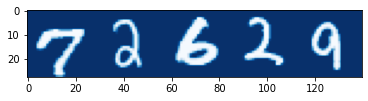

In [7]:
print(len(dataset))
print(dataset.image_list[0])
plt.imshow(dataset.image_list[0][0].numpy())
plt.show()

In [8]:
def hinge_loss(gen_perturb):
    return torch.sum(torch.clip(torch.norm(gen_perturb, dim=(-1, -2)) - threshold, min=0)) / batch_size

In [9]:
# set up models
discr_model = Discriminator().double()
gen_model = Generator().double()
# target_model = # YOLO Model

# record model architectures
with open(f'GANs_training/{run_name}/discriminator_architecture_summary.txt', 'w+') as f:
    f.write(str(discr_model))
    
with open(f'GANs_training/{run_name}/generator_architecture_summary.txt', 'w+') as f:
    f.write(str(gen_model))

In [10]:
from ultralytics import YOLO
from ultralytics.yolo.v8.detect.train import DetectionTrainer
from ultralytics.yolo.data.dataloaders.v5loader import create_dataloader
from ultralytics.yolo.v8.detect.train import Loss
import cv2
import torch
import matplotlib.pyplot as plt
import resize_right
import numpy as np

# load detection trainer using the weights best.pt
# best.pt is the custom model trained on YOLO_data_je
trainer = DetectionTrainer('args_digits_data_ver1.yaml')
trainer.setup_model()
trainer.model.double()
trainer.set_model_attributes()

Ultralytics YOLOv8.0.82 🚀 Python-3.9.12 torch-1.12.1 CPU
yolo/engine/trainer: task=detect, mode=predict, model=model_results/model_digit_data_ver1_256/weights/best.pt, data=detection_data.yaml, epochs=100, patience=50, batch=32, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=None, exist_ok=False, pretrained=False, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, 

In [11]:
# track metrics
loss_discr_list = []
loss_gen_list = []

loss_discr_by_epoch_list = []
loss_gen_by_epoch_list = []

In [12]:
# set up or refresh optimizers
optimizer_discr = torch.optim.Adam(discr_model.parameters(), lr=learning_rate_discr, amsgrad=True)
optimizer_gen = torch.optim.Adam(gen_model.parameters(), lr=learning_rate_gen, amsgrad=True)

In [43]:
# train
discr_model.train()
gen_model.train()

for epoch in range(num_epochs):
    discr_loss_epoch, gen_loss_epoch = 0, 0
    for batch_id, (images, classes, annotations) in enumerate(dataset_loader):
        images = images.double()
        classes = classes.double()
        annotations = annotations.double()

        tensor_img = images.repeat(1, 3, 1, 1)
        
        discr_loss, gen_loss = 0, 0
        
        for discr_i in range(discr_iters):
            gen_perturb = gen_model(tensor_img)
            images_perturb = tensor_img + gen_perturb
            
            loss_discr = net.compute_discr_loss_minimax(discr_model, tensor_img, images_perturb)
            
            optimizer_discr.zero_grad()
            loss_discr.backward()
            optimizer_discr.step()
            
            discr_loss += loss_discr.item()
            discr_loss_epoch += loss_discr.item()

        loss_discr_list.append(discr_loss / discr_iters)

        for gen_i in range(gen_iters):
            gen_perturb = gen_model(tensor_img)
            images_perturb = tensor_img + gen_perturb
            
            tensor_img_resized = resize_right.resize(images_perturb, out_shape=(1,3,256,256))
            batch = {'ori_shape': ((3, 28, 140),),
                'ratio_pad': None,
                'im_file': None,
                'img': tensor_img_resized,
                'cls': classes.squeeze(0),
                'bboxes': annotations.squeeze(0),
                'batch_idx': torch.zeros(classes.shape[1])
            }
            
            yolo_out = trainer.model(tensor_img_resized)
            loss_fn = Loss(trainer.model)
            loss_adv, _ = loss_fn(yolo_out, batch)
            loss_adv *= -1
            
            loss_gan = net.compute_gen_loss_minimax_modified(discr_model, images_perturb)
            
            loss_hinge = hinge_loss(gen_perturb)
            
            loss_gen = loss_adv + alpha * loss_gan + beta * loss_hinge
            
            gen_model.zero_grad()
            loss_gen.backward()
            optimizer_gen.step()
            
            gen_loss += loss_gen.item()
            gen_loss_epoch += loss_gen.item()

        loss_gen_list.append(gen_loss / gen_iters)
            
        if batch_id % 10 == 0:
            print('---------------------------------------------------------------------------------------------------------------------')
            print(f'epoch: {epoch}; batch: {batch_id}; discr loss: {discr_loss / discr_iters}; gen loss: {gen_loss / gen_iters}')
            print(f'adv loss: {loss_adv}; gan loss: {loss_gan}; hinge loss: {loss_hinge}; (from last batch)')
            
    loss_discr_by_epoch_list.append(discr_loss_epoch / len(dataset_loader) / discr_iters)
    loss_gen_by_epoch_list.append(gen_loss_epoch / len(dataset_loader) / gen_iters)

---------------------------------------------------------------------------------------------------------------------
epoch: 0; batch: 0; discr loss: 0.012881568245613557; gen loss: -9.841421705976234
adv loss: -42.545623779296875; gan loss: 4.980851398720846; hinge loss: 2.7969279778290197; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 0; batch: 10; discr loss: 0.007881536045612161; gen loss: -12.62552128248057
adv loss: -43.95952606201172; gan loss: 5.752778777915047; hinge loss: 2.437510158491887; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 0; batch: 20; discr loss: 0.007043833272724596; gen loss: -13.691042809129572
adv loss: -44.014747619628906; gan loss: 5.7368505136729455; hinge loss: 2.389416904508974; (from last batch)
------------------------------------------------------------------

KeyboardInterrupt: 

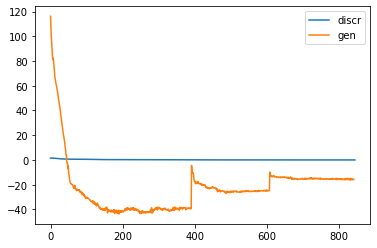

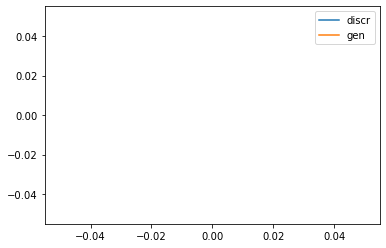

In [44]:
# plot loss graphs
plt.plot(loss_discr_list, label='discr')
plt.plot(loss_gen_list, label='gen')
plt.legend()
plt.savefig(f"GANs_training/{run_name}/loss_graph.png")
plt.show()

plt.plot(loss_discr_by_epoch_list, label='discr')
plt.plot(loss_gen_by_epoch_list, label='gen')
plt.legend()
plt.savefig(f"GANs_training/{run_name}/loss_graph_by_epoch.png")
plt.show()

In [45]:
torch.save(discr_model.state_dict(), f'GANs_training/{run_name}/discriminator_state_dict')
torch.save(gen_model.state_dict(), f'GANs_training/{run_name}/generator_state_dict')

original


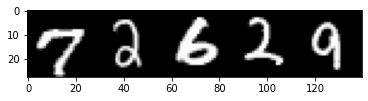

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbation


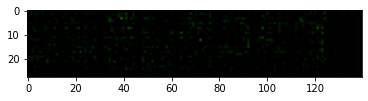

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbed image


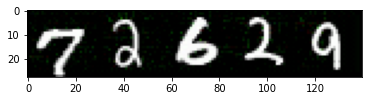

In [46]:
gen_model.eval()
with torch.no_grad():
    x = dataset.image_list[0].unsqueeze(0)
    tensor_img = x.repeat(1, 3, 1, 1)
    perturb = gen_model(tensor_img)
    x_perturbed = tensor_img + perturb

tensor_img = tensor_img.squeeze(0).permute(1, 2, 0)
perturb = perturb.squeeze(0).permute(1, 2, 0)
x_perturbed = x_perturbed.squeeze(0).permute(1, 2, 0)
    
print('original')
plt.imshow(tensor_img)
plt.show()
print('perturbation')
plt.imshow(perturb)
plt.show()
print('perturbed image')
plt.imshow(x_perturbed)
plt.show()

In [47]:
x_perturbed_shaped = x_perturbed.permute(2, 0, 1).unsqueeze(0)
x_perturbed_reshaped = resize_right.resize(x_perturbed_shaped, out_shape=(1,3,256,256))

In [48]:
tensor_img_shaped = tensor_img.permute(2, 0, 1).unsqueeze(0)
tensor_img_reshaped = resize_right.resize(tensor_img_shaped, out_shape=(1,3,256,256))

In [49]:
yolo_out = trainer.model(x_perturbed_reshaped)
yolo_out2 = trainer.model(tensor_img_reshaped)

In [50]:
yolo_out[0].shape

torch.Size([1, 74, 32, 32])

In [51]:
yolo_out[1].shape

torch.Size([1, 74, 16, 16])

In [52]:
yolo_out[2].shape

torch.Size([1, 74, 8, 8])

In [53]:
(yolo_out[0] - yolo_out2[0]).max()

tensor(26.2832, dtype=torch.float64, grad_fn=<MaxBackward1>)

### Summary of Training Procedure

*give summary here to save*

In [54]:
# make sure to save notebook before running this cell
shutil.copyfile('training.ipynb', f'GANs_training/{run_name}/training.ipynb')

'GANs_training/GANs_training_1/training.ipynb'

original


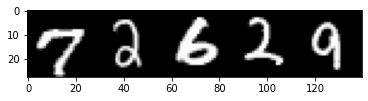

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbation


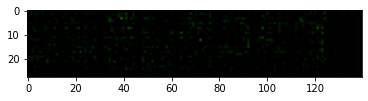

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbed image


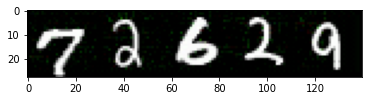

original


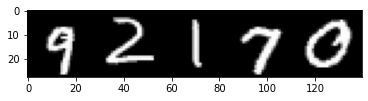

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbation


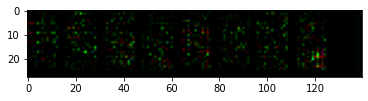

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbed image


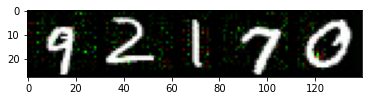

original


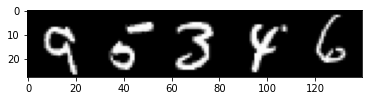

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbation


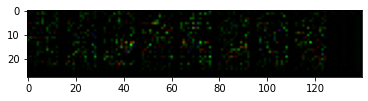

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbed image


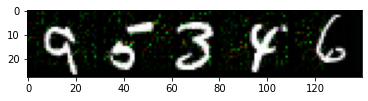

original


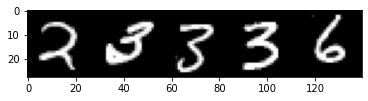

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbation


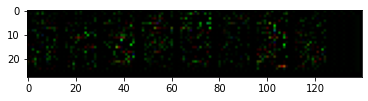

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbed image


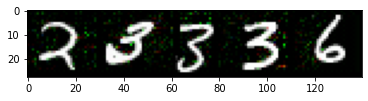

original


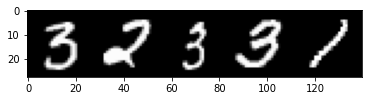

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbation


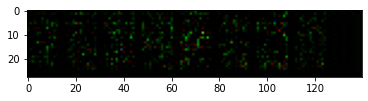

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbed image


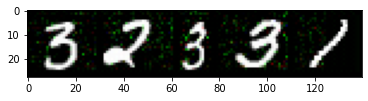

In [55]:
from torchvision.utils import save_image
gen_model.eval()
for i in range(5):
    with torch.no_grad():
        x = dataset.image_list[i].unsqueeze(0)
        tensor_img = x.repeat(1, 3, 1, 1)
        perturb = gen_model(tensor_img)
        x_perturbed = tensor_img + perturb

    tensor_img = tensor_img.squeeze(0).permute(1, 2, 0)
    perturb = perturb.squeeze(0).permute(1, 2, 0)
    x_perturbed = x_perturbed.squeeze(0).permute(1, 2, 0)

    print('original')
    plt.imshow(tensor_img)
    plt.show()
    print('perturbation')
    plt.imshow(perturb)
    plt.show()
    print('perturbed image')
    plt.imshow(x_perturbed)
    plt.show()
    
    save_image(tensor_img.permute(2, 0, 1), f'sample_perturbed_images/original_{i}.png')
    save_image(perturb.permute(2, 0, 1), f'sample_perturbed_images/perturbation_{i}.png')
    save_image(x_perturbed.permute(2, 0, 1), f'sample_perturbed_images/perturbed_{i}.png')

original


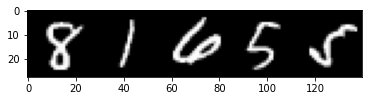

perturbation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


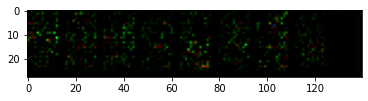

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbed image


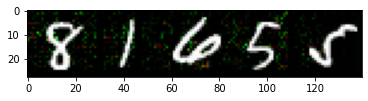

original


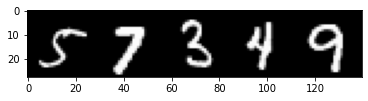

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbation


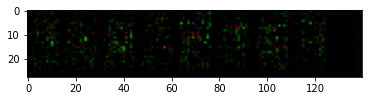

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbed image


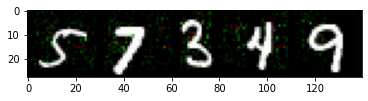

original


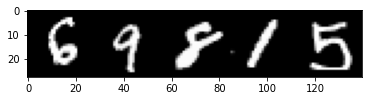

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbation


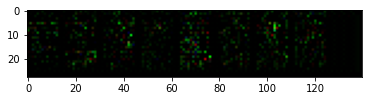

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbed image


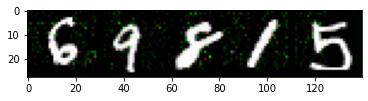

original


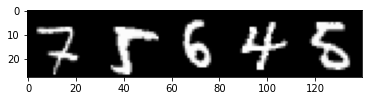

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbation


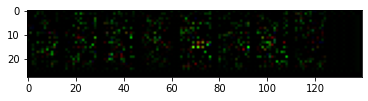

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbed image


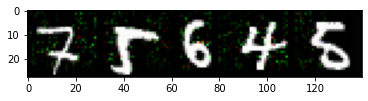

original


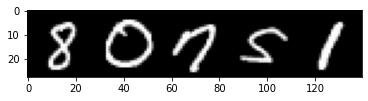

perturbation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


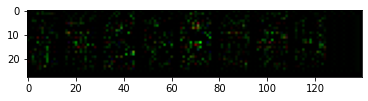

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbed image


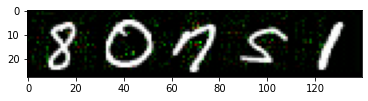

In [56]:
from torchvision.utils import save_image
gen_model.eval()
for i in range(len(dataset.image_list) - 5, len(dataset.image_list)):
    with torch.no_grad():
        x = dataset.image_list[i].unsqueeze(0)
        tensor_img = x.repeat(1, 3, 1, 1)
        perturb = gen_model(tensor_img)
        x_perturbed = tensor_img + perturb

    tensor_img = tensor_img.squeeze(0).permute(1, 2, 0)
    perturb = perturb.squeeze(0).permute(1, 2, 0)
    x_perturbed = x_perturbed.squeeze(0).permute(1, 2, 0)

    print('original')
    plt.imshow(tensor_img)
    plt.show()
    print('perturbation')
    plt.imshow(perturb)
    plt.show()
    print('perturbed image')
    plt.imshow(x_perturbed)
    plt.show()
    
    save_image(tensor_img.permute(2, 0, 1), f'sample_perturbed_images/original_{i}.png')
    save_image(perturb.permute(2, 0, 1), f'sample_perturbed_images/perturbation_{i}.png')
    save_image(x_perturbed.permute(2, 0, 1), f'sample_perturbed_images/perturbed_{i}.png')